In [1]:
import numpy as np
from qutip import *
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import math

In [2]:
from modules.spin_arch import *
from modules.su_algebra import *

In [3]:
from IPython.display import Latex

In [4]:
Ntrunc = 4 #global operator for truncation level or total number of dimensions

In [ ]:
#entire process involves 3 steps
## 1) Evolution by H
## 2) Encoding \theta by applying U = e^{iJ\theta}
## 3) Measurement using some projections

### Hamiltonian: 
$$
H' = \sum_{n,i} \left(\frac{(g^n_{i-1})^2 \mathcal H(i)}{v^n_{i-1} - \omega} + v^n_i - \Delta_i \right) \sigma^n_{i,i} +  \frac{1}{2} \sum_{n \neq m,i}\frac{g^n_{i}g^m_{i}}{\omega - v^m_{i}} ( \sigma^n_{i,i+1}\sigma^m_{i+1,i} + \sigma^n_{i+1,i}\sigma^m_{i,i+1} )
$$

where $\mathcal H(i) = 1$ for $i>0$, otherwise 0.

### Parameters:
$$v^n_{i-1} = (\sqrt{8 E^n_c E^n_j})i - 0.5*E^n_c i (i+1) $$
with default values set as $v \approx 60 * 100Mhz$, $g = 100Mhz$, $\omega = 55*100MHz$ 

In [5]:
#initialize system
N = 4
Nlevel = Ntrunc
Ej, Ec, g_arr, omega = generate_tmon_arch(N,Nlevel)
sys1 = tmon_system(N, Nlevel, Ec, Ej, g_arr, omega)

In [6]:
sys1.freq_list()

[[0.0, 60.745553203367585, 118.99110640673517],
 [0.0, 60.745553203367585, 118.99110640673517],
 [0.0, 60.745553203367585, 118.99110640673517],
 [0.0, 60.745553203367585, 118.99110640673517]]

In [7]:
sys1.self_energy

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

### Hamiltonian Evolution: $$e^{-iHt} \rho_0 e^{iHt}$$

In [8]:
psi_2 = (basis(Nlevel,0) + basis(Nlevel,1) + basis(Nlevel,2))
psi_2 = psi_2/psi_2.norm()
psi_2 = psi_2 * psi_2.dag()
psi_2

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.33333333 0.33333333 0.33333333 0.        ]
 [0.33333333 0.33333333 0.33333333 0.        ]
 [0.33333333 0.33333333 0.33333333 0.        ]
 [0.         0.         0.         0.        ]]

In [9]:
#(1)
#Evolution of a particular \rho with H' and \t
#simply solve the U\rhoU' for different thetas
H = sys1.H_I()
psi0 = tensor([psi_2]*N) #sys1.tensor_projection_op(0,1,1, dim = None)
times = np.linspace(0,10000,500) #time scale is ~ 1/freq of self energy 
options = Options()
options.store_final_state = True
result = mesolve(H, psi0, times, [], options = options, progress_bar=True)
print(len(result.states))

10.0%. Run time:  20.67s. Est. time left: 00:00:03:06
20.0%. Run time:  43.36s. Est. time left: 00:00:02:53
30.0%. Run time:  64.48s. Est. time left: 00:00:02:30
40.0%. Run time:  84.76s. Est. time left: 00:00:02:07
50.0%. Run time: 104.96s. Est. time left: 00:00:01:44
60.0%. Run time: 125.17s. Est. time left: 00:00:01:23
70.0%. Run time: 145.89s. Est. time left: 00:00:01:02
80.0%. Run time: 166.28s. Est. time left: 00:00:00:41
90.0%. Run time: 186.64s. Est. time left: 00:00:00:20
Total run time: 206.63s
500


In [10]:
pop_arr = []
Jx_arr = []
for i in tqdm(range(N)):
    temp = []
    temp2 = []
    for state in result.states:
        temp.append(abs(expect(state.ptrace(i), create(Nlevel)*destroy(Nlevel))))
        temp2.append(abs(expect(state.ptrace(i),Qobj((op_padded(sigmax(),Nlevel))))))
    pop_arr.append(temp)
    Jx_arr.append(temp2)
    #print(sum(temp))

  0%|          | 0/4 [00:00<?, ?it/s]

Text(0, 0.5, 'n')

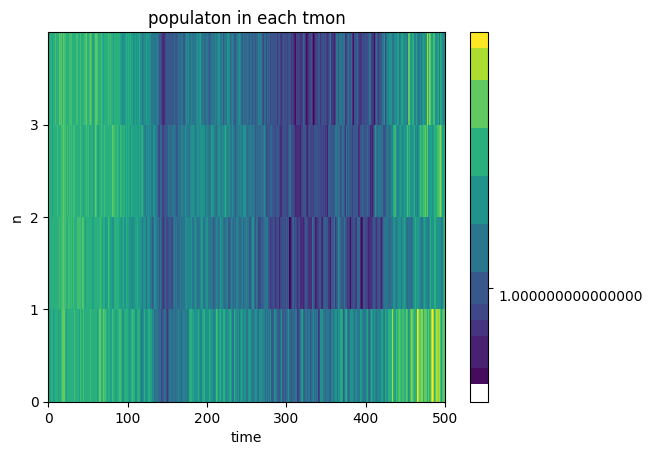

In [11]:
plt.pcolormesh(pop_arr)
plt.colorbar()
#plt.xticks()
plt.title("populaton in each tmon")
plt.yticks(range(N))
plt.xlabel("time")
plt.ylabel("n")

Text(0, 0.5, 'index of tmons')

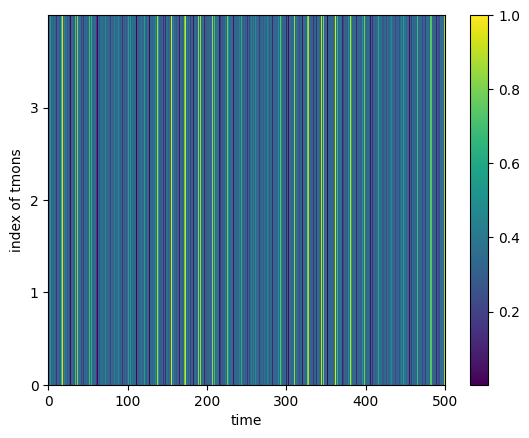

In [12]:
plt.pcolormesh(Jx_arr)
plt.colorbar()
#plt.xticks(times[times%5==0])
plt.yticks(range(N))
plt.xlabel("time")
plt.ylabel("index of tmons")

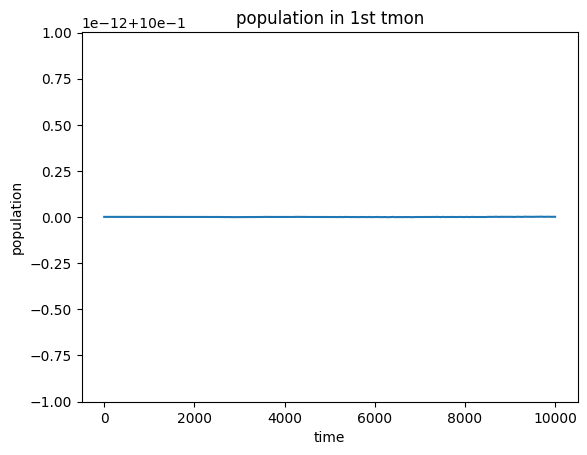

In [13]:
plt.plot(times, pop_arr[0])
plt.title("population in 1st tmon")
plt.xlabel("time")
plt.ylabel("population")
plt.show()

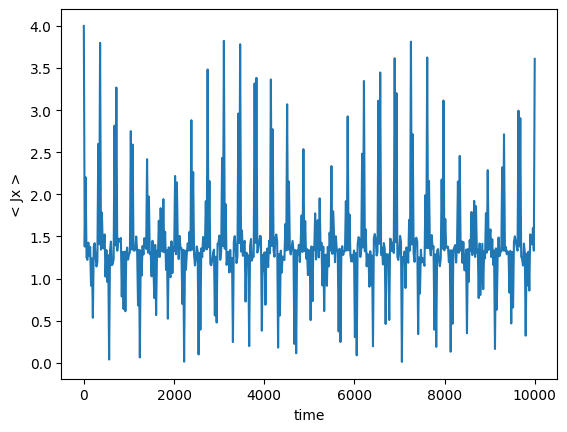

In [14]:
plt.plot(times, np.add(np.add(np.add(Jx_arr[0], Jx_arr[1]),Jx_arr[2]), Jx_arr[3]))
plt.xlabel("time")
plt.ylabel("< Jx >")
plt.show()

### For pure states: $$F_{\psi} = 4 \Delta J^2_n = nCn^T \quad \quad C_{\alpha,\beta} = Cov<J_\alpha, J_\beta> = \frac{1}{2}[<J_\alpha J_\beta>+ <J_\beta J_\alpha>] - <J_\alpha><J_\beta>$$ where: $$<O> = Tr(\rho O) $$

In [ ]:
#pauli matrices assuming just qubits
#no padding req for 2 dim though
Jx = Qobj(0.5*ensemble_op(op_padded(sigmax(),Nlevel), N))
Jy = Qobj(0.5*ensemble_op(op_padded(sigmay(),Nlevel), N))
Jz = Qobj(0.5*ensemble_op(op_padded(sigmaz(),Nlevel), N))

J_arr = [Jx,Jy,Jz]

In [22]:
#spin1 using tensor operators, but only Sx,Sy,Sz
sx,sy,sz, s1,s2,s3,s4,s5 = spin1_tensorop()
Jx = Qobj(ensemble_op(op_padded(sx,Nlevel), N))
Jy = Qobj(ensemble_op(op_padded(sy,Nlevel), N))
Jz = Qobj(ensemble_op(op_padded(sz,Nlevel), N))
J1 = Qobj(ensemble_op(op_padded(s1,Nlevel), N))
J2 = Qobj(ensemble_op(op_padded(s2,Nlevel), N))
J3 = Qobj(ensemble_op(op_padded(s3,Nlevel), N))
J4 = Qobj(ensemble_op(op_padded(s4,Nlevel), N))
J5 = Qobj(ensemble_op(op_padded(s5,Nlevel), N))

J_arr = [Jx,Jy,Jz,J1,J2,J3,J4,J5]
#J_arr = [Jx,Jy,Jz]

In [19]:
#gellmann matrices
l1,l2,l3,l4,l5,l6,l7,l8 = gellmann_matrices()
Jx = Qobj(ensemble_op(op_padded(l1,Nlevel), N))
Jy = Qobj(ensemble_op(op_padded(l2,Nlevel), N))
Jz = Qobj(ensemble_op(op_padded(l3,Nlevel), N))
J1 = Qobj(ensemble_op(op_padded(l4,Nlevel), N))
J2 = Qobj(ensemble_op(op_padded(l5,Nlevel), N))
J3 = Qobj(ensemble_op(op_padded(l6,Nlevel), N))
J4 = Qobj(ensemble_op(op_padded(l7,Nlevel), N))
J5 = Qobj(ensemble_op(op_padded(l8,Nlevel), N))

J_arr = [Jx,Jy,Jz,J1,J2,J3,J4,J5]
#J_arr = [Jx,Jy,Jz]

In [16]:
#Calculation of covariance matrix
# for now step (2,3) can be avoided as exact analytical results avaialble
# FI = n^T C n
def C_matrix(rho, J_arr):
    #do a dimension check for rho and J_arr[i] as well
    d = len(J_arr)
    C = np.zeros((d,d), dtype=complex)
    for i in range(d):
        for j in range(d):
            C[i][j] = 0.5*((rho*J_arr[i]*J_arr[j]).tr()+ (rho*J_arr[j]*J_arr[i]).tr())- (rho*J_arr[i]).tr()*(rho*J_arr[j]).tr()
    return C

In [23]:
#Maximum Eigenvalue
#when n is the eigenvector with maximum eigen value of C, FI is maximized
# Define the matrix
FI_max_arr = []
optimal_evec = []
i = 0
#temp_arr = []
for state in tqdm(result.states):
    matrix = C_matrix(state, J_arr)
    eigenvalues, eigenvectors = np.linalg.eig(matrix)
    #temp_arr.append([str(i) + "time step: " + str(np.around(eigenvalues.real, 4))])
    print(str(i) + "time step: " + str(np.around(eigenvalues.real, 4)))
    max_index = np.argmax(eigenvalues)
    max_eigenvalue = eigenvalues[max_index]
    max_eigenvector = eigenvectors[max_index]
    FI_max_arr.append(4*max_eigenvalue)
    optimal_evec.append(max_eigenvector)
    i = i+1



  0%|          | 0/500 [00:00<?, ?it/s]

0time step: [ 8.2861 -0.2861 -0.     -0.      2.6667  0.      0.      0.    ]
1time step: [-5.9963  8.3168  0.      3.9665  2.6602  0.      0.      0.    ]
2time step: [ 9.1313 -3.8469  5.2712 -0.      1.2706  0.      0.      0.    ]
3time step: [-4.4277  8.0949  6.0934  0.      2.602   0.      0.      0.    ]
4time step: [-4.0264  0.      5.3738  2.5862  7.9802  0.      0.      0.    ]
5time step: [-5.3049  8.0375  0.      4.3466  2.5861  0.      0.      0.    ]
6time step: [-5.2997  8.1393  0.      4.2639  2.2791  0.      0.      0.    ]
7time step: [-4.6585  0.      5.8621  2.6193  7.8827  0.      0.      0.    ]
8time step: [ 7.7901 -2.4339  0.      0.8159  2.5361  0.      0.      0.    ]
9time step: [-4.5645  8.0782 -0.      4.6604  2.6634  0.      0.      0.    ]
10time step: [ 8.7859 -2.428   4.3362  0.      1.1839  0.      0.      0.    ]
11time step: [-5.258   0.      8.0753  5.3156  2.6408  0.      0.      0.    ]
12time step: [-4.1208  8.3078  6.1989 -0.      2.3525  0.     

105time step: [-4.6101  7.4676  5.3449 -0.      2.3469  0.      0.      0.    ]
106time step: [-5.1274  8.0698  0.      4.2314  2.232   0.      0.      0.    ]
107time step: [-6.1142  0.      7.9996  4.5545  2.6368  0.      0.      0.    ]
108time step: [-5.6815 -0.      8.0492  4.8943  2.6444  0.      0.      0.    ]
109time step: [-4.8654  8.0212  5.7099 -0.      1.8929  0.      0.      0.    ]
110time step: [-5.6658  0.      8.0584  4.9389  2.661   0.      0.      0.    ]
111time step: [ 9.5618 -2.3109  3.8757 -0.      1.3089  0.      0.      0.    ]
112time step: [-5.8332 10.0865  0.      2.3657  2.6667  0.      0.      0.    ]
113time step: [ 7.992  -3.2983  0.      4.1367  2.1465  0.      0.      0.    ]
114time step: [-4.7326  9.1619  0.      3.6571  2.255   0.      0.      0.    ]
115time step: [-6.0587  8.0623 -0.      4.4483  2.6396  0.      0.      0.    ]
116time step: [-6.14    0.      8.005   4.3111  2.5635  0.      0.      0.    ]
117time step: [-5.5367  8.1385 -0.      

209time step: [-3.7355  8.1269  5.3184 -0.      1.2708  0.      0.      0.    ]
210time step: [-5.0117  0.      5.6493  8.0022  2.664   0.      0.      0.    ]
211time step: [-4.0126  8.1935  6.3338  0.      2.559   0.      0.      0.    ]
212time step: [-4.0067  8.087   6.0769 -0.      2.5062  0.      0.      0.    ]
213time step: [-4.98    8.7585  0.      4.7648  2.4299  0.      0.      0.    ]
214time step: [-4.6757  7.4776  5.3837  0.      2.3843  0.      0.      0.    ]
215time step: [ 8.3449 -3.2421 -0.      1.3389  2.5211  0.      0.      0.    ]
216time step: [-3.5613  0.      6.4134  7.6719  2.6604  0.      0.      0.    ]
217time step: [ 7.959  -3.0588  3.4719 -0.      1.3557  0.      0.      0.    ]
218time step: [-5.4064  0.      5.257   8.0021  2.6665  0.      0.      0.    ]
219time step: [-4.6704  8.0596  6.2292  0.      2.1293  0.      0.      0.    ]
220time step: [-4.0342  8.1721  6.3326  0.      2.5802  0.      0.      0.    ]
221time step: [-4.3088  8.1074  6.0728  

312time step: [-3.9273  8.6217  4.7806  0.      1.7025  0.      0.      0.    ]
313time step: [-5.0808  8.6948  0.      4.6689  2.4081  0.      0.      0.    ]
314time step: [-5.9964  8.0635 -0.      4.0735  2.5715  0.      0.      0.    ]
315time step: [-6.4437  7.9973  0.      4.131   2.5419  0.      0.      0.    ]
316time step: [-5.2376  8.016   4.6462 -0.      2.1953  0.      0.      0.    ]
317time step: [-5.1029  0.      5.5356  7.9947  2.6625  0.      0.      0.    ]
318time step: [ 8.5906 -1.7376  3.4429 -0.      1.2846  0.      0.      0.    ]
319time step: [-6.3459  8.7065 -0.      3.0673  2.6667  0.      0.      0.    ]
320time step: [ 9.5049 -2.3506  3.7119 -0.      1.4249  0.      0.      0.    ]
321time step: [-4.9765  9.103  -0.      4.5092  2.4994  0.      0.      0.    ]
322time step: [-4.9992  7.9018  5.2201  0.      2.488   0.      0.      0.    ]
323time step: [-5.922   8.0527  0.      4.133   2.3787  0.      0.      0.    ]
324time step: [-6.2056  0.      7.9632  

418time step: [-4.9561  0.      2.4974  5.8039  7.976   0.      0.      0.    ]
419time step: [-4.4769  8.2137  6.2725  0.      2.2019  0.      0.      0.    ]
420time step: [-4.8403  8.2593  5.5681 -0.      2.5973  0.      0.      0.    ]
421time step: [-3.8523  8.4814  4.6687  0.      1.7731  0.      0.      0.    ]
422time step: [10.4037 -4.4945  0.      1.7091  2.6358  0.      0.      0.    ]
423time step: [-3.597  -0.      7.1085  5.5684  2.6243  0.      0.      0.    ]
424time step: [ 8.0559 -3.6372 -0.      2.9616  1.9853  0.      0.      0.    ]
425time step: [-5.287  -0.      5.3533  8.015   2.663   0.      0.      0.    ]
426time step: [-5.234   8.122   5.2449  0.      2.2518  0.      0.      0.    ]
427time step: [-4.9881  0.      2.4843  5.774   7.9766  0.      0.      0.    ]
428time step: [-4.8425 -0.      5.8188  8.      2.6607  0.      0.      0.    ]
429time step: [-4.1131  9.0856  5.3208  0.      1.4768  0.      0.      0.    ]
430time step: [10.0349 -5.2337  0.      

In [ ]:
#temp_arr2 = temp_arr
#temp_arr2

Text(0, 0.5, 'F_max')

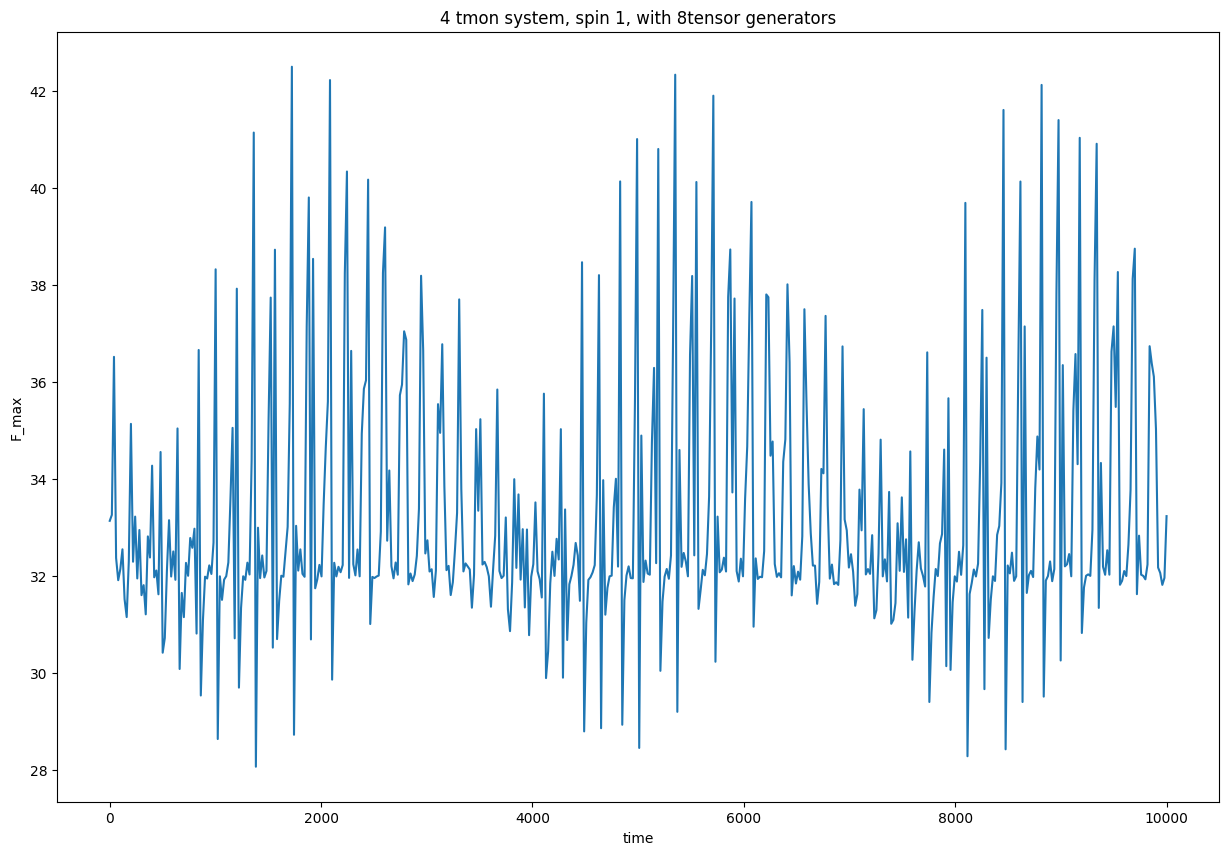

In [24]:
#Plot FI_max vs time/\theta
plt.figure(figsize=(15,10))
plt.plot(times,FI_max_arr)
plt.title(str(N) + " tmon system, spin 1, with "+str(len(J_arr))+ "tensor generators")
plt.xlabel("time")
plt.ylabel("F_max")

In [ ]:
def is_hermitian(matrix):
    return np.allclose(matrix, matrix.conj().T)

def cartesian_to_spherical(vec):
    """Converts a cartesian coordinate (x, y, z) into a spherical one (radius, theta, phi)."""
    x = vec[0]
    y = vec[1]
    z = vec[2]
    radius = np.sqrt(x * x + y * y + z * z)
    theta = math.atan2(np.sqrt(x * x + y * y), z)
    #theta = math.acos(z/radius)
    phi = math.atan2(y, x)
    return [radius, theta, phi]

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0:
        return v
    return v / norm

In [ ]:
#plot for optimal eigenvectors
spherical_coordinates = []
for vec in optimal_evec:
    spherical_coordinates.append(cartesian_to_spherical(vec.real))

In [ ]:
spherical_coordinates = np.array(spherical_coordinates) 

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(times,spherical_coordinates[:,1], label  = "theta")
plt.plot(times,spherical_coordinates[:,2], label = 'phi')
plt.plot(times,FI_max_arr/max(FI_max_arr),alpha =0.5 , label = "FI_max rescaled", linestyle='dashed')
plt.title(str(N) + " tmon system, spin 1, with "+str(len(J_arr))+ " generators")
plt.xlabel("time")
plt.ylabel("angle in radians")
plt.legend()

In [ ]:
#Graph of FI vs time


In [ ]:
#(2)
#Encode \theta by applying U = e^{i n.J \theta}
psi_i = results.states #for FI vs time graph
n = np.array([1,0,0]) #ideally the max eigenvalue eigenvector
J_arr = np.array([]) #generators or their subset
theta_arr = np.linspace(0, 0.5, 2) #values of theta to encode
#code for n.J
result2 = mesolve(n*J_arr, psi_i, times, [], options = options)

In [ ]:
#Fisher Info Calculation
def purestate_FI(J,psi):
    FI = 4*variance(J,psi)
    return FI

In [ ]:
FI_list = []
for psi in result.states:
    FI_list.append(purestate_FI(H,psi))

plt.plot(times,FI_list)
plt.xlabel("time")
plt.ylabel("Finsher Info")

In [ ]:
#pauli operators for the tmon system
#initialize
N = 3 #number of transmons
Nlevel = Ntrunc
# spin = 1
# dim = spin*2+1

#padded operators
jx = op_padded(jmat(spin,'x'), Nlevel)
jy = op_padded(jmat(spin,'y'), Nlevel)
jz = op_padded(jmat(spin,'z'), Nlevel)
#combined spin operators
JX = 0
JY = 0
JZ = 0
for i in range(N):
    JX.append(ensemble_op(jx,i,N))
    JY.append(ensemble_op(jx,i,N))
    JZ.append(ensemble_op(jx,i,N))

In [ ]:
#calculate optimal squeezing parameter
H_cap = [] #array of all operators being considered
##calculate covariance matrix
##calculate commutator matrix
def calculate_covariance(matrix1, matrix2):
    # Check if the matrices have the same shape
    if matrix1.shape != matrix2.shape:
        raise ValueError("Matrices must have the same shape.")
    
    # Calculate the covariance
    covariance = np.cov(matrix1, matrix2, bias=True)
    
    return covariance

def covariance_matrix(H_cap):
    tau = np.zeros((len(H_cap),len(H_cap)))
    for k in range(len(H_cap)):
        for l in range(len(H_cap)):
            tau[k][l] = calculate_covariance(H_cap[k],H_cap(l))

In [ ]:
'''
#Hamiltonian for a set of transmons coupled to a mode
class tmon_system:
    def __init__(self,N, Nlevel, E_C, E_j, g_arr, omega):
        self.N = N #value of n goes from 0 to N-1
        self.Nlevel = Nlevel #cut off dimension/truncation
        #This is different from d which is the level that comes into hamiltonian.
        #d refers to the highest excitation present in the initialised state
        #d  by default is set to (Nlevel-2) as (d+1) at max can be (Nlevel-1)
        self.d = Nlevel-2
        self.E_c= E_c
        self.E_j = E_j
        self.g_arr = g_arr #g^n_i = g_arr[n][i]
        self.omega = omega #freq of photonic mode
        self.v_arr = self.freq_list() #v[n][i] = v^n_i
    
    def freq_list(self):
        #calculate v^n_i
        #for |i><i|_n, coefficient is  \sqrt(8E^n_j*E^n_c)*i - E^n_c/2*i(i+1)
        arr = []
        for n in range(self.N):
            temp_arr = []
            for i in range(self.d+1):
                v_ni = np.sqrt(8*self.E_c[n]*self.E_j[n])*i - 0.5*self.E_c[n]*i*(i+1)
                temp_arr.append(v_ni)
            arr.append(temp_arr) 
        return arr
    
    def cal_delta(self):
        #simplest version is to equate to average over transmons i.e n
        delta_arr = []
        
        for n in range(self.N):
            temp = 0
            for i in range(self.d +1):
                temp = temp + ((self.g_arr[n][i]**2)*np.heaviside(i,0)/(self.v_arr[n][i-1]-self.omega)+self.v_arr[n][i])
            delta_arr.append(temp/(self.d+1))
        return delta_arr
    
    def tensor_id(self, dim = None):
        if dim ==None:
            dim = self.d+2
        #IxIxIxI...Ioperator
        Neye = []
        for i in  range(self.N):
            Neye.append(qeye(dim))
        nid = tensor(Neye)
        return nid
          
    def tensor_projection_op(self,n,i,j, dim = None):
        #returns IxIxIx...(|i><j|_n)xIxI...xI
        if n > self.N-1:
            print("invalid n")
            return
        if dim ==None:
            dim = self.d+2
            
        Neye = []
        for k in  range(self.N):
            Neye.append(qeye(dim))
        #(|i><j|_n)
        Neye[n] = basis(dim,i)*basis(dim,j).dag()
        nid = tensor(Neye)
        return nid
        
    def H_I(self, delta_arr = None):
        #rotataed time indp effective hamiltonian
        #lambda_arr contains \Delta_i to be added as self energy corrections
        if delta_arr==None:
            delta_arr = self.cal_delta()
        
        H0 = 0
        for n in range(self.N):
            for i in range(self.d + 1):
                c_ni = (self.g_arr[n][i-1]**2)*np.heaviside(i,0)/(self.v_arr[n][i-1]- self.omega) + self.v_arr[n][i] - delta_arr[i]
                H0 = H0 + c_ni*self.tensor_projection_op(n,i,i)
        
        H1 = 0
        for n in range(self.N):
            for m in range(self.N):
                for i in range(self.d + 1):
                    if n == m:
                        break
                    c_nmi = 0.5*(self.g_arr[n][i]*self.g_arr[m][i])/(self.omega - self.v_arr[m][i])
                    H1 = H1 + c_nmi*(self.tensor_projection_op(n,i,i+1)*self.tensor_projection_op(m,i+1,i) + self.tensor_projection_op(n,i+1,i)*self.tensor_projection_op(m,i,i+1))
        
        return H0 + H1

def generate_tmon_arch(N,Nlevel):
    #scaling is 1 to 100MHz
    E_j =  np.absolute(np.random.normal(200,20, N))
    E_c = np.absolute(np.random.normal(2.5,0.2, N))
    g_arr = np.zeros((N,Nlevel))
    for n in range(N):
        for i in range(Nlevel):
            g_arr[n][i] = 1
    omega = 2
    return E_j, E_c, g_arr,omega 
'''

In [ ]:
"""
#create spin operators
class operators:
    def __init__(self, N, spin):
        self.N = N
        self.spin =spin
        
    
    def generators_arr(self):
        #return all generators for a spin-n algebra
        return
    
    def tensor_operator(self,op,i):
        #returns IxIxIx...(op_i)xIxI...xI
        if i > self.N-1:
            raise ValueError("index needs to be between 0 and"+str(self.N)+"-1")

        Neye = []
        for k in  range(self.N):
            Neye.append(qeye(self.spin))
        #(op_i)
        Neye[n] = basis(dim,i)*basis(dim,j).dag()
        nid = tensor(Neye)
        return nid
        
    def J_n(self,n):
        #\sum (n.J)_i
        #it should take both 3x1 and dx1 vectors
        #3x1 leads to use of just sigma x,y,z
        #dx1 leads to use of all generators
        jx = jmat(i, 'x')
        jy = jmat(i, 'y')
        jz = jmat(i, 'z')
        
        
     
    def nonlin_operators(self, degree):
        #take array of generators and combine them to get non-lin operators
        #return vector with non-lin operators only
        lin_op_arr = self.generators_arr
        nonlin_arr = []
"""